# StyleSense Review Recommendation Model

Welcome to the StyleSense machine learning project! This project aims to predict whether a customer would recommend a clothing item based on their review, age, product category, and other metadata.

StyleSense, a growing online women's fashion retailer, is facing a challenge: many customer reviews are missing the "Recommended" label. Our goal is to use reviews with complete data to train a machine learning model that can predict this missing information. This will help:

1. Improve product recommendations
2. Understand customer sentiment
3. Identify top-performing items

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Import Libraries

In [2]:
# Install spacy
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.9 MB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [48]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

nlp = spacy.load('en_core_web_sm')

## Load Data

In [19]:
# Load data
df = pd.read_csv(
    'data/reviews.csv',
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Preparing features (`X`) & target (`y`)

In [20]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [21]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

# Your Work

## Data Exploration

In [27]:
#Checking for rows and columns
print("Shape of data:", df.shape)

#Checking for data types
print("\nColumn types:\n", df.dtypes)

#Missing value count in each column
print("\nMissing values:\n", df.isnull().sum())

Shape of data: (18442, 9)

Column types:
 Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
Recommended IND             int64
dtype: object

Missing values:
 Clothing ID                0
Age                        0
Title                      0
Review Text                0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
Recommended IND            0
dtype: int64


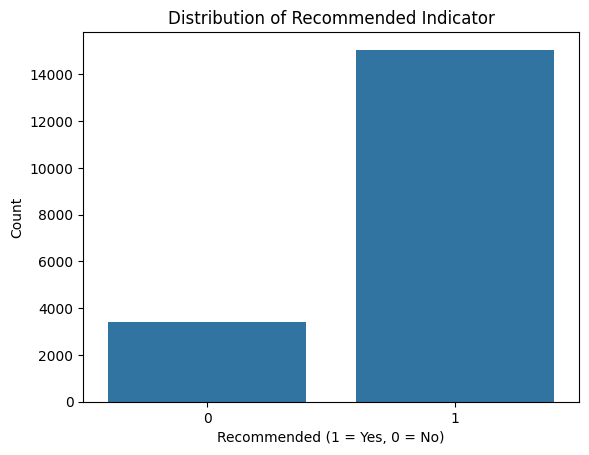

In [28]:
# Target variable distribution
sns.countplot(data=df, x="Recommended IND")
plt.title("Distribution of Recommended Indicator")
plt.xlabel("Recommended (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

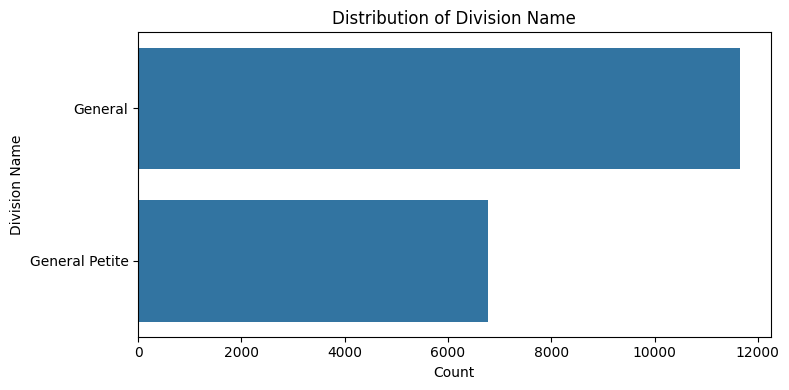

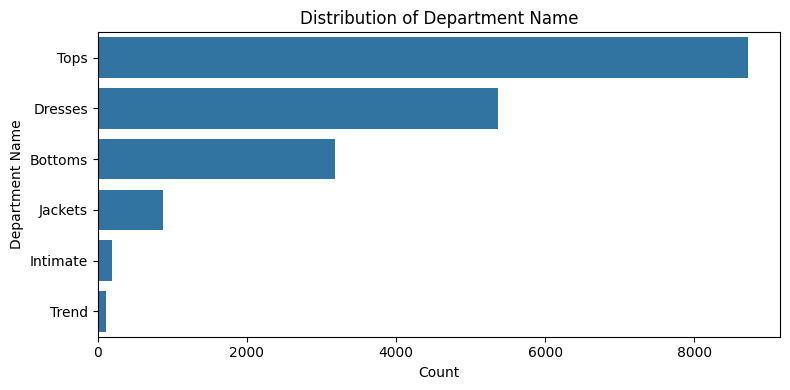

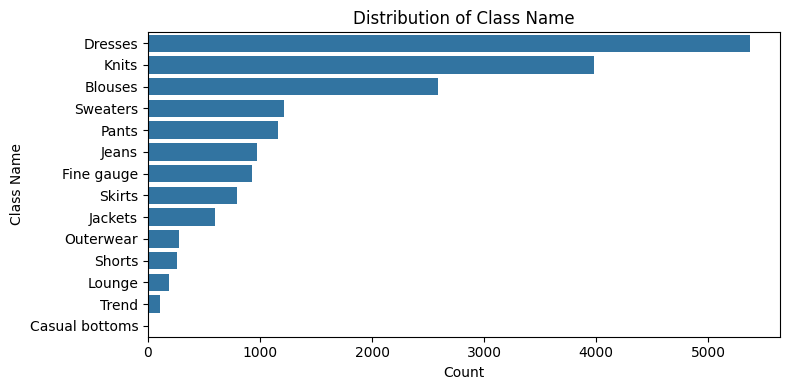

In [29]:
for col in ["Division Name", "Department Name", "Class Name"]:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, y=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

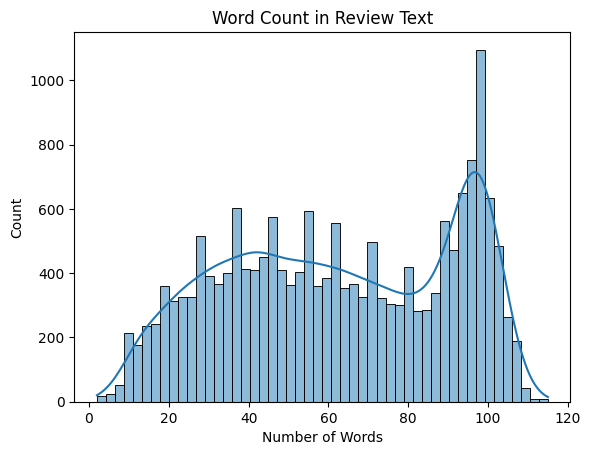

In [30]:
# Word count in review text
review_length = df["Review Text"].apply(lambda x: len(str(x).split()))
sns.histplot(review_length, bins=50, kde=True)
plt.title("Word Count in Review Text")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

## Building Pipeline

In [32]:
# Define column types
text_col = "Review Text"
num_cols = ["Age", "Positive Feedback Count"]
cat_cols = ["Division Name", "Department Name", "Class Name"]

In [37]:
# Preprocessing for categorical and numerical cols
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [46]:
#Creating a custom transformer to count characters
class CountCharacter(BaseEstimator, TransformerMixin):
    def __init__(self, character: str):
        self.character = character

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [[text.count(self.character)] for text in X]

In [49]:
text_preprocessing = Pipeline([
    (
        'dimension_reshaper',
        FunctionTransformer(
            np.reshape,
            kw_args={'newshape':-1},
        ),
    ),
])

# Creating feature engineering pipeline for counting the number of spaces, `!`, and `?`

feature_engineering = FeatureUnion([
    ('count_spaces', CountCharacter(character=' ')),
    ('count_exclamations', CountCharacter(character='!')),
    ('count_question_marks', CountCharacter(character='?')),
])

character_counts_pipeline = Pipeline([
    (
        'initial_text_preprocess',
        text_preprocessing,
    ),
    (
        'feature_engineering',
        feature_engineering,
    ),
])
character_counts_pipeline

Pipeline(steps=[('initial_text_preprocess',
                 Pipeline(steps=[('dimension_reshaper',
                                  FunctionTransformer(func=<function reshape at 0x7d259c0eea70>,
                                                      kw_args={'newshape': -1}))])),
                ('feature_engineering',
                 FeatureUnion(transformer_list=[('count_spaces',
                                                 CountCharacter(character=' ')),
                                                ('count_exclamations',
                                                 CountCharacter(character='!')),
                                                ('count_question_marks',
                                                 CountCharacter(character='?'))]))])

In [50]:
# Creating the spacy lemmatizer to lematize the reviews text
class SpacyLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lemmatized = [
            ' '.join(
                token.lemma_ for token in doc
                if not token.is_stop
            )
            for doc in self.nlp.pipe(X)
        ]
        return lemmatized   

In [51]:
# Creating a vector representation of the reviews text
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_pipeline = Pipeline([
    (
        'dimension_reshaper',
        FunctionTransformer(
            np.reshape,
            kw_args={'newshape':-1},
        ),
    ),
    (
        'lemmatizer',
        SpacyLemmatizer(nlp=nlp),
    ),
    (
        'tfidf_vectorizer',
        TfidfVectorizer(
            stop_words='english',
        ),
    ),
])
tfidf_pipeline 

Pipeline(steps=[('dimension_reshaper',
                 FunctionTransformer(func=<function reshape at 0x7d259c0eea70>,
                                     kw_args={'newshape': -1})),
                ('lemmatizer',
                 SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x7d256f3e3fa0>)),
                ('tfidf_vectorizer', TfidfVectorizer(stop_words='english'))])

In [52]:
# Combining all the preprocessing and feature engineering steps
from sklearn.compose import ColumnTransformer

feature_engineering = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ('character_counts', character_counts_pipeline, text_col),
        ('tfidf_text', tfidf_pipeline, text_col),
])

feature_engineering

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Age', 'Positive Feedback Count']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Division Name', 'Department Name',
                                  'Class Name']),
                                ('character_counts',
                                 Pipeline(steps=[('initial_text_preprocess',
                                                  Pipeline(steps=[('dimension_reshaper',
                                                                   FunctionTransformer(func=<function reshape at 0x7d259c0eea70>,
                                                                                       kw_args=...
                                                                                 ('count_question_marks',
                                                                                  CountCharacter(character='?'))]))]),
                                 'Review Text'),
                                ('tfidf_text',
                                 Pipeline(steps=[('dimension_reshaper',
                                                  FunctionTransformer(func=<function reshape at 0x7d259c0eea70>,
                                                                      kw_args={'newshape': -1})),
                                                 ('lemmatizer',
                                                  SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x7d256f3e3fa0>)),
                                                 ('tfidf_vectorizer',
                                                  TfidfVectorizer(stop_words='english'))]),
                                 'Review Text')])

## Training Pipeline

In [53]:
# Training the model using the random forest classifier and creating a model pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

model_pipeline = make_pipeline(
    feature_engineering,
    RandomForestClassifier(random_state=27),
)

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Positive Feedback Count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Division Name',
                                                   'Department Name',
                                                   'Class Name']),
                                                 ('character_counts',
                                                  Pipeline(steps=[('initial_text_preprocess',
                                                                   Pipeline(steps=[('dimension_reshaper',
                                                                                    FunctionTransformer(func=<func...
                                                  Pipeline(steps=[('dimension_reshaper',
                                                                   FunctionTransformer(func=<function reshape at 0x7d259c0eea70>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x7d256f3e3fa0>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'Review Text')])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=27))])

In [59]:
# Evaluating the model predictions using accuracy, precision, recall and f1score
from sklearn.metrics import classification_report

y_pred_forest_pipeline = model_pipeline.predict(X_test)
classification_forest_pipeline = classification_report(y_test, y_pred_forest_pipeline)

print('Classification Report:', classification_forest_pipeline)

Classification Report:               precision    recall  f1-score   support

           0       0.77      0.19      0.30       327
           1       0.85      0.99      0.91      1518

    accuracy                           0.85      1845
   macro avg       0.81      0.59      0.61      1845
weighted avg       0.83      0.85      0.81      1845



## Fine-Tuning Pipeline

In [55]:
# Hyper parameter tuning to improve the model results and chosing the best parameters for the model
from sklearn.model_selection import RandomizedSearchCV

my_distributions = dict(
    randomforestclassifier__max_features=[
        100,
        150,
        250,
    ],
    randomforestclassifier__n_estimators=[
        150,
        200,
    ],
)

param_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=my_distributions,
    n_iter=6,     
    cv=5,         
    n_jobs=-1,    
    refit=True,   
    verbose=3, 
    random_state=27,
)

param_search.fit(X_train, y_train)

# Selecting the best parameters
param_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.847 total time= 1.7min
[CV 2/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.851 total time= 1.7min
[CV 3/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.844 total time= 1.7min
[CV 4/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.845 total time= 1.7min
[CV 5/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.847 total time= 1.7min
[CV 1/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=200;, score=0.848 total time= 1.7min
[CV 2/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=200;, score=0.851 total time= 1.7min
[CV 3/5] END randomforestclassifier__

{'randomforestclassifier__n_estimators': 150,
 'randomforestclassifier__max_features': 250}

In [56]:
best_model = param_search.best_estimator_
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Positive Feedback Count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Division Name',
                                                   'Department Name',
                                                   'Class Name']),
                                                 ('character_counts',
                                                  Pipeline(steps=[('initial_text_preprocess',
                                                                   Pipeline(steps=[('dimension_reshaper',
                                                                                    FunctionTransformer(func=<func...
                                                  Pipeline(steps=[('dimension_reshaper',
                                                                   FunctionTransformer(func=<function reshape at 0x7d259c0eea70>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x7d25146c1330>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'Review Text')])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=250, n_estimators=150,
                                        random_state=27))])

In [62]:
y_pred_forest_pipeline = best_model.predict(X_test)
results_forest_pipeline = classification_report(y_test, y_pred_forest_pipeline)

print('Classification Report:', results_forest_pipeline)

Classification Report:               precision    recall  f1-score   support

           0       0.74      0.30      0.42       327
           1       0.87      0.98      0.92      1518

    accuracy                           0.86      1845
   macro avg       0.80      0.64      0.67      1845
weighted avg       0.84      0.86      0.83      1845

